# Bitcoin Time Series Prediction of Return with LSTM

Import necessary library needed for the model training

install keras/Tensorflow in conda first


In [73]:
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline


I downloaded the dataset from Investing.com with features "price" and "change%"(return) included. Next, load the data.

In [74]:
data = pd.read_csv('Bitcoin Historical Data - Investing.com.csv', index_col="Date")

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1734 entries, 7/1/2017 to 3/30/2022
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     1734 non-null   object
 1   Open      1734 non-null   object
 2   High      1734 non-null   object
 3   Low       1734 non-null   object
 4   Vol.      1734 non-null   object
 5   Change %  1734 non-null   object
dtypes: object(6)
memory usage: 94.8+ KB


check data info and no missing values

In [76]:
data.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
7/1/2017,"2,424.60","2,480.60","2,529.60","2,387.50",66.32K,-2.26%
7/2/2017,"2,536.50","2,424.60","2,555.30","2,375.90",67.76K,4.61%
7/3/2017,"2,572.50","2,536.50","2,617.50","2,506.30",83.42K,1.42%
7/4/2017,"2,617.30","2,572.50","2,658.70","2,570.00",80.68K,1.74%
7/5/2017,"2,627.90","2,617.30","2,642.70","2,562.00",89.72K,0.40%


From the first 5 rows of the data and the info, all numerical columns need to be dealt with to remove the comma. Transform volumn into numerical data and Date column to be "date" form, and remove "%" in the Change(return) column.

In [77]:
# define a function to remove the comma of Price, Open, High and Low and convert them to float numbers

def commaremove(col): 
    res = []
    for s in col:
        s = s.replace(',', '')
        s = s.replace('.', '')
        s = float(s)
        s = s/10
        res.append(s)
    return res

In [78]:
Price = list(data['Price'])
Pricenum = commaremove(Price)

Open = list(data['Open'])
Opennum = commaremove(Open)

High = list(data['High'])
Highnum = commaremove(High)

Low = list(data['Low'])
Lownum = commaremove(Low)




In [79]:
data['Price'] = Pricenum
data['Open'] = Opennum
data['High'] = Highnum
data['Low'] = Lownum

In [80]:
data.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
7/1/2017,24246.0,24806.0,25296.0,23875.0,66.32K,-2.26%
7/2/2017,25365.0,24246.0,25553.0,23759.0,67.76K,4.61%
7/3/2017,25725.0,25365.0,26175.0,25063.0,83.42K,1.42%
7/4/2017,26173.0,25725.0,26587.0,25700.0,80.68K,1.74%
7/5/2017,26279.0,26173.0,26427.0,25620.0,89.72K,0.40%


In [81]:
# define a function to remove the last number unit of Vol. and convert them to float numbers

def unitremove(col): 
    res = []
    for s in col:
        if s[-1] == 'M':
            s = s.replace('M', '')
            s = s.replace('.', '')
            s = float(s)
            s = s*10000
        elif s[-1] == 'B':
            s = s.replace('B', '')
            s = s.replace('.', '')
            s = float(s)
            s = s*10000000
        elif s[-1] == 'K':
            s = s.replace('K', '')
            s = s.replace('.', '')
            s = float(s)
            s = s*10
        res.append(s)
    return res

In [82]:
Vol = list(data['Vol.'])
Volnum = unitremove(Vol)
data['Vol.'] = Volnum

In [83]:
data.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
7/1/2017,24246.0,24806.0,25296.0,23875.0,66320.0,-2.26%
7/2/2017,25365.0,24246.0,25553.0,23759.0,67760.0,4.61%
7/3/2017,25725.0,25365.0,26175.0,25063.0,83420.0,1.42%
7/4/2017,26173.0,25725.0,26587.0,25700.0,80680.0,1.74%
7/5/2017,26279.0,26173.0,26427.0,25620.0,89720.0,0.40%


In [84]:
# define a function to remove the percent sign of Change and convert them to float numbers

def perremove(col): 
    res = []
    for s in col:
        s = s.replace('%', '')
        s = s.replace('.', '')
        if s[0] == '-':
            s = s.replace('-', '')
            s = float(s)
            s = -s/10000
        else:
            s = float(s)
            s = s/10000
        res.append(s)
    return res

In [85]:
Change = list(data['Change %'])
Changenum = perremove(Change)
data['return'] = Changenum

In [86]:
data.head()

,Price,Open,High,Low,Vol.,Change %,return
Date,,,,,,,
7/1/2017,24246.0,24806.0,25296.0,23875.0,66320.0,-2.26%,-0.0226
7/2/2017,25365.0,24246.0,25553.0,23759.0,67760.0,4.61%,0.0461
7/3/2017,25725.0,25365.0,26175.0,25063.0,83420.0,1.42%,0.0142
7/4/2017,26173.0,25725.0,26587.0,25700.0,80680.0,1.74%,0.0174
7/5/2017,26279.0,26173.0,26427.0,25620.0,89720.0,0.40%,0.0040


In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1734 entries, 7/1/2017 to 3/30/2022
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     1734 non-null   float64
 1   Open      1734 non-null   float64
 2   High      1734 non-null   float64
 3   Low       1734 non-null   float64
 4   Vol.      1734 non-null   float64
 5   Change %  1734 non-null   object 
 6   return    1734 non-null   float64
dtypes: float64(6), object(1)
memory usage: 108.4+ KB


Plot line graph based on Price

In [88]:
btc_trace = go.Scatter(x = data.index, y = data['Price'], name= 'Price')
py.iplot([btc_trace])

Based on the graph of the price on a per day base, the price went higher and higher from 7/1/2017 to 1/3/2018 and kept fluctuating until 11/9/2018. 
And then went down a little bit and then kept still until 4/13/2019. 
After that, the price went up until 7/1/2019 and stood almost still until 10/22/2020. I belive that here is a huge event happened and finance was affected dramatically. 
The price went higher than 600K and then kept great fluctuation until 5/1/2021 and then a huge event happened again to cause the price droped a lot within short term. 
Then the price went down a little bit until 7/1/2021 and then got higher a lot until 9/3/2021.
During these one year time period, the price fluctuated very frequently with great change.
It went up high again until 11/8/2021 and then went down until 1/23/2022 and then went up again quickly within 2 weeks and kept fluctuated a lot.
I believe the big event is Covid-19 and the price is highly related to the job-lose rates and mask rules.

Find corrleration in features

<AxesSubplot:>

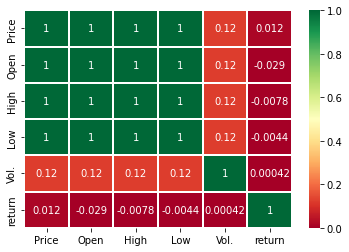

In [89]:
data = data.drop(columns=['Change %'])
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

All four prices are highly correlated, as expected. The target return is not highly correlated with others, which is great, so we can use all features to predict the return.

In [90]:
# Function to convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [91]:
values = data[['return'] + ['Price'] + ['Open'] + ['High'] + ['Low'] + ['Vol.']].values
values = values.astype('float32')

Normalize features to range from 0 to 1 with MinMaxScaler

In [92]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [93]:
# Frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
1,0.570281,0.007780,0.008634,0.007248,0.008965,0.000015,0.676398,0.009486,0.007780,0.007632,0.008786,0.000015
2,0.676398,0.009486,0.007780,0.007632,0.008786,0.000015,0.627124,0.010034,0.009486,0.008561,0.010807,0.000019
3,0.627124,0.010034,0.009486,0.008561,0.010807,0.000019,0.632067,0.010717,0.010034,0.009176,0.011794,0.000018
4,0.632067,0.010717,0.010034,0.009176,0.011794,0.000018,0.611369,0.010879,0.010717,0.008937,0.011670,0.000020
5,0.611369,0.010879,0.010717,0.008937,0.011670,0.000020,0.597158,0.010670,0.010879,0.008819,0.011977,0.000013


In [94]:
# Drop unncessary columns
reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
1,0.570281,0.007780,0.008634,0.007248,0.008965,0.000015,0.676398
2,0.676398,0.009486,0.007780,0.007632,0.008786,0.000015,0.627124
3,0.627124,0.010034,0.009486,0.008561,0.010807,0.000019,0.632067
4,0.632067,0.010717,0.010034,0.009176,0.011794,0.000018,0.611369
5,0.611369,0.010879,0.010717,0.008937,0.011670,0.000020,0.597158


Split data to 75% training dataset, 25% testing dataset

In [95]:
values = reframed.values
n_train_hours = int(len(values) * 0.75)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1299, 1, 6) (1299,) (434, 1, 6) (434,)


In [96]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

Training the LSTM model with 100 epochs

In [97]:
modelnew = Sequential()
modelnew.add(LSTM(128,input_shape=(train_X.shape[1], train_X.shape[2])))
modelnew.add(Dropout(0.2))
modelnew.add(Dense(1))
modelnew.compile(loss='mean_squared_error', optimizer='adam')
historymodel = modelnew.fit(train_X, train_y, epochs=100, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 1299 samples, validate on 434 samples
Epoch 1/100
 - 1s - loss: 0.2816 - val_loss: 0.1059
Epoch 2/100
 - 0s - loss: 0.1610 - val_loss: 0.0116
Epoch 3/100
 - 0s - loss: 0.0745 - val_loss: 0.0695
Epoch 4/100
 - 0s - loss: 0.0278 - val_loss: 0.2507
Epoch 5/100
 - 0s - loss: 0.0141 - val_loss: 0.3636
Epoch 6/100
 - 0s - loss: 0.0121 - val_loss: 0.3258
Epoch 7/100
 - 0s - loss: 0.0107 - val_loss: 0.2505
Epoch 8/100
 - 0s - loss: 0.0098 - val_loss: 0.2009
Epoch 9/100
 - 0s - loss: 0.0098 - val_loss: 0.1719
Epoch 10/100
 - 0s - loss: 0.0091 - val_loss: 0.1489
Epoch 11/100
 - 0s - loss: 0.0086 - val_loss: 0.1292
Epoch 12/100
 - 0s - loss: 0.0084 - val_loss: 0.1093
Epoch 13/100
 - 0s - loss: 0.0079 - val_loss: 0.0900
Epoch 14/100
 - 0s - loss: 0.0078 - val_loss: 0.0767
Epoch 15/100
 - 0s - loss: 0.0078 - val_loss: 0.0645
Epoch 16/100
 - 0s - loss: 0.0073 - val_loss: 0.0545
Epoch 17/100
 - 0s - loss: 0.0071 - val_loss: 0.0446
Epoch 18/100
 - 0s - loss: 0.0070 - val_loss: 0.0372
Epoch 19

Plot line graph to show amount loss according the the epoch

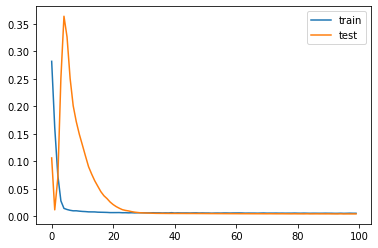

In [98]:
plt.plot(historymodel.history['loss'], label='train')
plt.plot(historymodel.history['val_loss'], label='test')
plt.legend()
plt.show()

Make prediction using textX and plotting line graph against testY

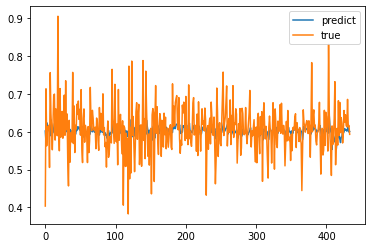

In [99]:
yhat = modelnew.predict(test_X)
plt.plot(yhat, label='predict')
plt.plot(test_y, label='true')
plt.legend()
plt.show()

In [100]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [101]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.042


Plot line graph with actual return, predicted return with four price features and volume

In [102]:
predictDates = data.index
yhat_reshape = inv_yhat.reshape(len(inv_yhat))
actual_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Return')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Predict Return')
py.iplot([actual_chart, multi_predict_chart])

Check the results of the prediction and RMSE, the model is acceptable considering the small RMSE and correct increasing or decreasing intendency of the target.